In [3]:
#from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import keras_tuner as kt
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Exploração inicial

In [4]:
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

print("---------Cifar 100---------")
print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")
print(f"Min: {x_train.min()}")
print(f"Max: {x_train.max()}")
print(f"Média: {x_train.mean():.2f}")
print(f"Desvio Padrão: {x_train.std():.2f}")

#print("---------Cifar 10---------")
#print(f"Train shape: {x_train.shape}")
#print(f"Test shape: {x_test.shape}")
#print(f"Min: {x_train.min()}")
#print(f"Max: {x_train.max()}")
#print(f"Média: {x_train.mean():.2f}")
#print(f"Desvio Padrão: {x_train.std():.2f}")

x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

#x_train2 = x_train2.astype('float32')/255.0
#x_test2 = x_test2.astype('float32')/255.0

---------Cifar 100---------
Train shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)
Min: 0
Max: 255
Média: 121.94
Desvio Padrão: 68.39


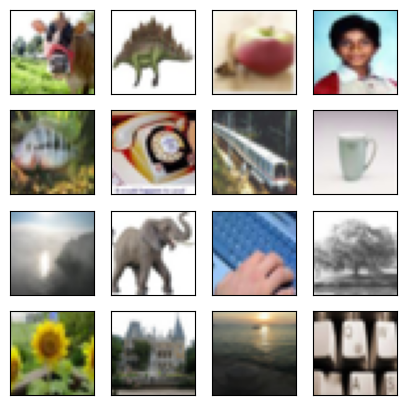

In [5]:
plt.figure(figsize = (5,5))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()

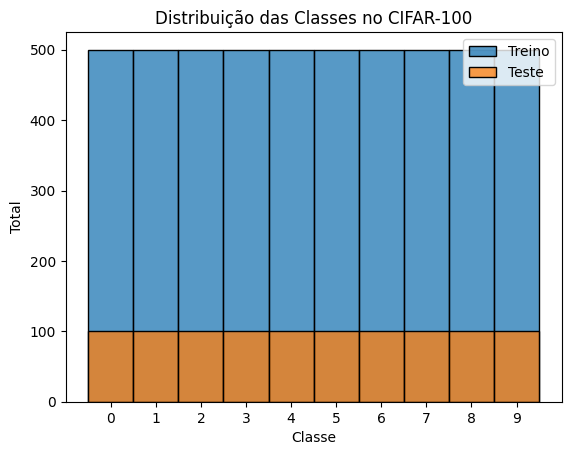

In [6]:
sns.histplot(y_train.flatten(), bins = np.arange(11)-0.5)
#sns.histplot(y_train2.flatten(), bins = np.arange(11)-0.5)
plt.xticks(range(10))

sns.histplot(y_test.flatten(), bins = np.arange(11)-0.5)
#sns.histplot(y_test2.flatten(), bins = np.arange(11)-0.5)
plt.xticks(range(10))
plt.xlabel("Classe")
plt.ylabel("Total")
plt.title("Distribuição das Classes no CIFAR-100")
plt.legend(["Treino", "Teste"])
plt.show()

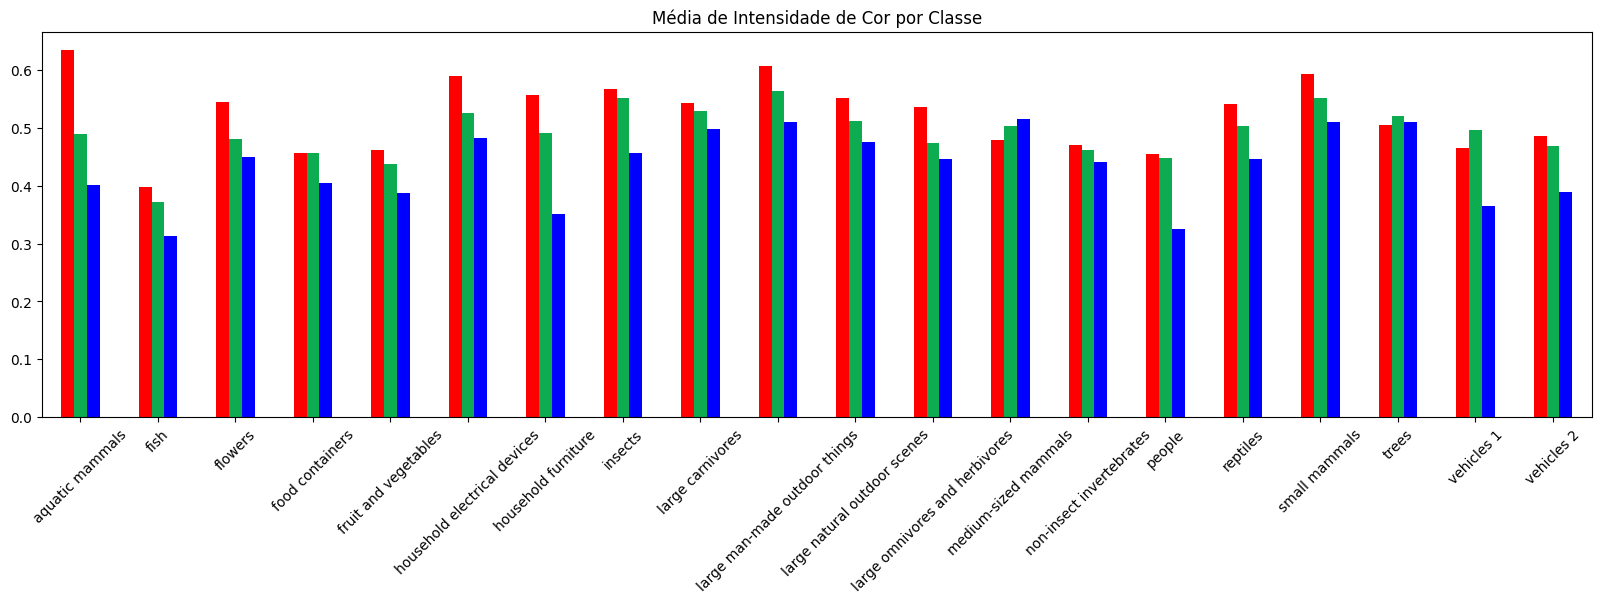

In [7]:
#names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
names = ['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices',
         'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes',
         'large omnivores and herbivores', 'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
         'trees', 'vehicles 1', 'vehicles 2']

means = {c: np.mean(x_train[y_train.flatten() == i], axis=(0, 1, 2)) for i, c in enumerate(names)}
#means = {c: np.mean(x_train2[y_train2.flatten() == i], axis=(0, 1, 2)) for i, c in enumerate(names)}

df = pd.DataFrame(means).T
cores = ['Red', '#0DAC50', 'Blue']

df.plot(kind = 'bar', figsize = (20, 5), color = cores)
plt.title("Média de Intensidade de Cor por Classe")
plt.xticks(rotation = 45)
plt.legend().remove()
plt.show()

Classe para guardar o Learning Rate

In [8]:
class LearningRateSaved(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LearningRateSaved, self).__init__()
        self.lrates = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if hasattr(lr, 'numpy'):
            self.lrates.append(lr.numpy())
        else:
            self.lrates.append(tf.keras.backend.get_value(lr))



In [ ]:
'''
Opções para experimentar depois

- Dense(units=hp.Int('dense_units', 64, 256, step=64), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
- GlobalAveragePooling2D() em vez de flatten
- kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
- Ver com mais layers
- Experimentar sem dropout nas convoluted
- Descobrir primeiro a learning rate, ver os gráficos e ver a melhor learning rate, depois fazer o random/grid search para os
restantes hiperparâmetros
'''

CNN sem data augmentation

In [20]:

def build_model_CNN_sda(hp):
    model = Sequential()
    #model.add(Conv2D(filters=hp.Int('conv1_filters', 64, 256, step=64), kernel_size=hp.Choice('kernel_size_1',values=[3,5]), activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=hp.Choice('pool_1',values=[2,4])))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    #model.add(Conv2D(filters=hp.Int('conv2_filters', 64, 256, step=64), kernel_size=hp.Choice('kernel_size_2',values=[3,5]), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=hp.Choice('pool_2',values=[2,4])))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    #model.add(Dense(units=hp.Int('dense_units', 64, 256, step=64), activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='softmax'))

    #lr = hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5, 1e-6])
    lr = 1e-3
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


CNN com data augmentation

In [ ]:
def build_model_CNN_da(hp):
  model = tf.keras.Sequential()
  
  model.add(RandomFlip('horizontal', input_shape=(32, 32, 3)))
  model.add(RandomRotation(0.05))
  model.add(RandomZoom(0.05))
  
  model.add(Conv2D(filters=hp.Int('filter_1',min_value=64,max_value=256,step=64),kernel_size=hp.Choice('kernel_size_1',values=[3,5]), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=hp.Choice('pool_1',values=[2,4])))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=hp.Int('filter_2',min_value=64,max_value=256,step=64),kernel_size=hp.Choice('kernel_size_2',values=[3,5]),activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=hp.Choice('pool_2',values=[2,4])))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(units=hp.Int('Unit_1',min_value=64,max_value=256,step=64),activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='softmax'))
  model.summary()

  lr = 1e-4
  model.compile(optimizer=lr,loss='categorical_crossentropy',metrics=['accuracy'])
  return model

MLP


In [ ]:
def build_model_mlp(hp):
  model = tf.keras.Sequential()
  
  model.add(Flatten(input_shape=(32, 32, 3)))

  model.add(Dense(units=hp.Int('Unit_1',min_value=128,max_value=512,step=128),activation='relu'))
  model.add(Dense(units=hp.Int('Unit_2',min_value=128,max_value=512,step=128),activation='relu'))
  model.add(Dense(units=100,activation='softmax'))

  lr = 1e-4
  optimizer_name = hp.Choice('optimizer', ['adam', 'sgd'])
  if optimizer_name == 'adam':
    optimizer = lr
  elif optimizer_name == 'sgd':
    optimizer = lr

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model


Random search

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner = kt.RandomSearch(
    #build_model_MLP
    #build_model_CNN_da
    build_model_CNN_sda,
    objective='val_accuracy',
    max_trials=10,
    #directory='/Cifar 100/cifar100_MLP_benchmarks',
    #directory='/Cifar 100/cifar100_CNN_da_benchmarks',
    #directory='/Cifar 100/cifar100_CNN_sda_benchmarks',
    #project_name='cifar100_MLP_benchmarks'
    #project_name='cifar100_CNN_da_benchmarks'
    #project_name='cifar100_CNN_sda_benchmarks'
)

tuner.search(
    x_train, y_train,
    epochs=25,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

Reloading Tuner from ./untitled_project/tuner0.json


Grid Search

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner = kt.GridSearch(
    #build_model_MLP
    #build_model_CNN_da
    build_model_CNN_sda,
    objective='val_accuracy',
    #max_trials=None,  
    # directory='/Cifar 100/cifar100_MLP_benchmarks',
    # directory='/Cifar 100/cifar100_CNN_da_benchmarks',
    #directory='/Cifar 100/cifar100_CNN_sda_benchmarks',
    #project_name='cifar100_MLP_benchmarks'
    #project_name='cifar100_CNN_da_benchmarks'
    #project_name='cifar100_CNN_sda_benchmarks'
)

tuner.search(
    x_train, y_train,
    epochs=25,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

Melhores Hiperparâmetros

In [37]:
melhores_modelos = tuner.get_best_models(num_models=1)[0]
# melhores_modelos.summary()
melhores_hiperparametros = tuner.get_best_hyperparameters(num_trials=1)[0]
melhores_hiperparametros.get_config()['values']

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


{'conv1_filters': 64,
 'dropout_rate1': 0.30000000000000004,
 'conv2_filters': 128,
 'dropout_rate2': 0.1,
 'dense_units': 256,
 'dropout_rate3': 0.4,
 'learning_rate': 0.0001}

Treino do melhor modelo

In [27]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, min_lr=1e-6)
lr_save = LearningRateSaved()

#melhor_model = tuner.hypermodel.build(melhores_hiperparametros)
melhor_model = build_model_CNN_sda(1)

x_train_part, x_val, y_train_part, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=4465)

history = melhor_model.fit(x_train_part, y_train_part, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stop,reduce_lr,lr_save], verbose = 1)


Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - accuracy: 0.0217 - loss: 4.6568 - val_accuracy: 0.0433 - val_loss: 4.3839 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.0345 - loss: 4.3957 - val_accuracy: 0.0613 - val_loss: 4.1589 - learning_rate: 0.0010
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.0449 - loss: 4.2839 - val_accuracy: 0.0832 - val_loss: 3.9847 - learning_rate: 0.0010
Epoch 4/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0523 - loss: 4.1831
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.0523 - loss: 4.1831 - val_accuracy: 0.0876 - val_loss: 4.0003 - learning_rate: 0.0010
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.0640 - loss: 4.0836 - val_accuracy: 0.1272 - val_loss: 3.7790 - learning_rate: 5.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accu

Gráficos de Acurracy e Loss em relação ao epochs

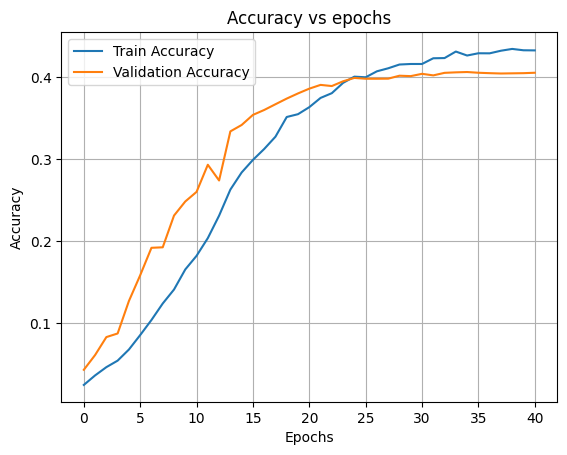

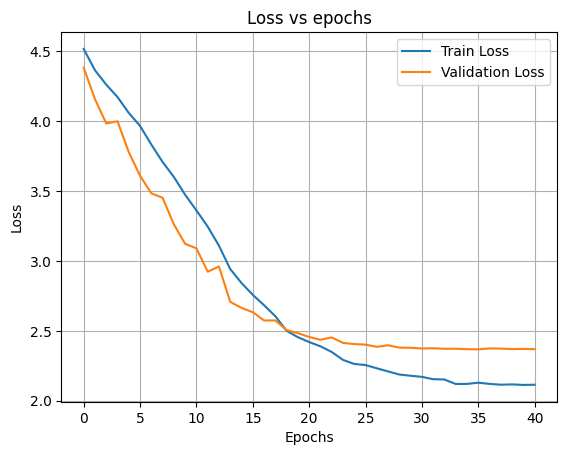

In [28]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

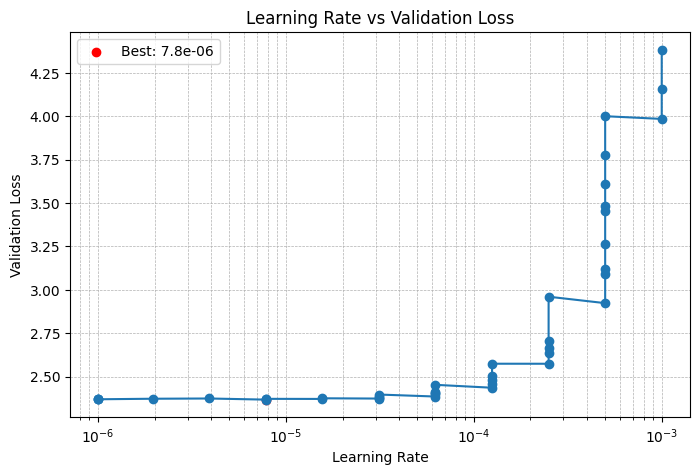

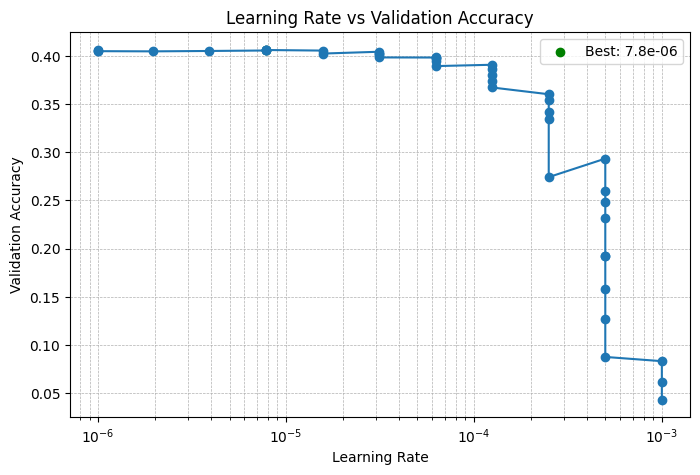

In [29]:
# Learning Rate vs Validation Loss
plt.figure(figsize=(8,5))
plt.plot(lr_save.lrates, history.history['val_loss'], marker='o', linestyle='-')
plt.xscale('log')
plt.title('Learning Rate vs Validation Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.grid(True, which="both", ls="--", lw=0.5)

# Anotar o melhor ponto (menor loss)
best_idx = np.argmin(history.history['val_loss'])
plt.scatter(lr_save.lrates[best_idx], history.history['val_loss'][best_idx], color='red', label=f'Best: {lr_save.lrates[best_idx]:.1e}')
plt.legend()
plt.show()

# Learning Rate vs Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(lr_save.lrates, history.history['val_accuracy'], marker='o', linestyle='-')
plt.xscale('log')
plt.title('Learning Rate vs Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.grid(True, which="both", ls="--", lw=0.5)

# Maior accuracy
best_idx = np.argmax(history.history['val_accuracy'])
plt.scatter(lr_save.lrates[best_idx], history.history['val_accuracy'][best_idx], color='green', label=f'Best: {lr_save.lrates[best_idx]:.1e}')
plt.legend()
plt.show()


Classification Report

In [ ]:
print(classification_report(y_val, y_pred_classes))

Guardar o modelo

In [ ]:
melhor_model.save('cifar100_CNN_sda.keras')
#melhor_model.save('cifar100_CNN_da.keras')
#melhor_model.save('cifar100_MLP.keras')